# Downloading datasets and installing packages
Uncomment to run; only necessary once for each user.
source: https://github.com/Noob-can-Compile/Automatic-Image-Captioning/

In [1]:
# #Gets validation data.
#
#!wget http://images.cocodataset.org/zips/val2014.zip
#!unzip val2014.zip -d images

In [2]:
# #Gets training data.

# !wget  http://images.cocodataset.org/zips/train2014.zip
# !unzip train2014.zip -d images

In [3]:
# #downloads and unzips train/val annotations.

# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !unzip annotations_trainval2014.zip 

In [4]:
# !wget http://images.cocodataset.org/annotations/image_info_test2014.zip
# !unzip image_info_test2014.zip

In [5]:
# #downloads and unzips test data
# !wget http://images.cocodataset.org/zips/test2014.zip
# !unzip 'test2014.zip' -d images

In [6]:
# #Install missing packages if modules not loaded
# !pip install --user torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install nltk

In [ ]:
# #Only use in Colab
# from google.colab import files

#!cd models

#files.download('encoder-1.pkl')

# Master import list

In [1]:
import json
import matplotlib.pyplot as plt
import math
import nltk
import numpy as np
import pickle
import os
import os.path
import random
import requests
import sys
import time
import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.data as data
from torchvision import transforms
from pycocotools.coco import COCO
from collections import Counter
from PIL import Image
from tqdm import tqdm

# Global definitions
Note that filenames will depend on the model and must be changed if you don't want to overwrite an existing log file or encoder/decoder .pkl

In [52]:
#nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#dataloader, encoder, and decoder settings
batch_size = 64          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 300           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder

#training loop
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss

#BE SURE TO CHANGE THESE FILENAMES IF YOU CHANGE THE CNN
log_file = 'training_log_model0vgg16.txt'       # name of file with saved training loss and perplexity
loss_file = "vgg13losses.txt"
perplexity_file = "vgg13perplexities.txt"

#Specify the saved models to load.
encoder_file = 'vgg13encoder-3.pkl'
decoder_file = 'vgg13decoder-3.pkl'

# Encoder/Decoder definitions
This model uses resnet50 as the encoder and an RNN with LSTM as the decoder.

In [53]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.vgg13(pretrained=True)
        
        #print(resnet)
        
        for param in resnet.parameters():
            param.requires_grad_(False)
        #resnet.classifier[6] = nn.Linear(512,embed_size)
        modules = list(resnet.children())[:-1]
        #remove avgpooling
        modules = nn.Sequential(*list(resnet.features._modules.values())[:-1])
        vggpooling = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.resnet = nn.Sequential(*modules, vggpooling)
                                       
        #print(self.resnet)                               
                                       
        #self.embed = nn.Linear(resnet.classifier[6].in_features, embed_size)
        self.embed = nn.Linear(512, embed_size)
    def forward(self, images):
        #print("resnet: ", self.resnet)
        features = self.resnet(images)
        #print("out of resnet: ", features.shape)
        features = features.view(features.size(0), -1)
        #print("out of view: ", features.shape)
        features = self.embed(features)
        #print("forward output shape: ", features.shape)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(input_size = embed_size,hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        captions = captions[:, :-1]
        embed = self.embedding_layer(captions)
        embed = torch.cat((features.unsqueeze(1), embed), dim = 1)
        lstm_outputs, _ = self.lstm(embed)
        out = self.linear(lstm_outputs)
        
        return out

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        output_sentence = []
        for i in range(max_len):
            lstm_outputs, states = self.lstm(inputs, states)
            lstm_outputs = lstm_outputs.squeeze(1)
            out = self.linear(lstm_outputs)
            last_pick = out.max(1)[1]
            output_sentence.append(last_pick.item())
            inputs = self.embedding_layer(last_pick).unsqueeze(1)
        
        return output_sentence

# Dataset and Vocabulary classes
Uses COCO dataset.

In [54]:
class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train' or self.mode == 'val':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train' or self.mode == 'val':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train' or self.mode == 'val':
            return len(self.ids)
        else:
            return len(self.paths)

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# Define dataloader modes

In [55]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc=''):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'val', 'test'], "mode must be one of 'train' or 'test'."
    #if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'annotations/image_info_test2014.json')
    if mode == 'val':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'images/val2014/')
        annotations_file = os.path.join(cocoapi_loc, 'annotations/captions_val2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train' or mode == 'val':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

# Training
## Define training dataloader
* define a transform to pre-process the training images
* initialize a training dataloader

In [56]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the training loader.
train_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

# Store the size of the vocabulary.
vocab_size = len(train_loader.dataset.vocab)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.61s)
creating index...


  0%|          | 875/414113 [00:00<00:47, 8747.07it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:47<00:00, 8670.56it/s]


## Initialize encoder and decoder

In [57]:
# Initialize the encoder and move to device
encoder = EncoderCNN(embed_size)
encoder.to(device)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /usr4/ec500/brianxu/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (

In [58]:
# Initialize the decoder and move to device
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.to(device)

DecoderRNN(
  (embedding_layer): Embedding(8852, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8852, bias=True)
)

### Trainloader/Encoder/Decoder debugging

In [59]:
# Randomly sample a caption length, and sample indices with that length.
indices = train_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
train_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(train_loader))
images = images.to(device)
captions = captions.to(device)
    
print('images.type:',images.type())    
print('images.shape:', images.shape)
print('captions.type:', captions.type())
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
#print('images:', images)
#print('captions:', captions)

sampled indices: [272654, 287666, 235341, 38172, 231039, 46890, 131941, 440, 20227, 362842, 45685, 101515, 45717, 171251, 61618, 115499, 230863, 136484, 219458, 71264, 189236, 31775, 239520, 314780, 87037, 244848, 157291, 235515, 175015, 234720, 243626, 145657, 194378, 25574, 31954, 245847, 260406, 314658, 214422, 357395, 299289, 27792, 217669, 186478, 100499, 88364, 80944, 12915, 190504, 263814, 388905, 324253, 99184, 250340, 139277, 192789, 356087, 112136, 137502, 275603, 317676, 299511, 221645, 221988]
images.type: torch.cuda.FloatTensor
images.shape: torch.Size([64, 3, 224, 224])
captions.type: torch.cuda.LongTensor
captions.shape: torch.Size([64, 12])


In [60]:
# Pass the images through the encoder.
features = encoder(images)

#check feature type and shape
print('type(features):', type(features))
print('features.shape:', features.shape)

assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

type(features): <class 'torch.Tensor'>
features.shape: torch.Size([64, 300])


In [61]:
# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)
print("features: ", features.shape)
print("captions: ", captions.shape)

assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([64, 12, 8852])
features:  torch.Size([64, 300])
captions:  torch.Size([64, 12])


## Define loss, optimizer, steps

Loss: Cross Entropy
Optimizer: Adam, lr = 0.001

In [62]:
# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params = params, lr = 0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(train_loader.dataset.caption_lengths) / train_loader.batch_sampler.batch_size)

## TRAIN (THIS CELL WILL TAKE A LONG TIME)

In [ ]:
# Open the training log file.
f = open(log_file, 'w')

losses = []
perplexities = []

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):        
        # Randomly sample a caption length, and sample indices with that length.
        indices = train_loader.dataset.get_train_indices()
        
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        train_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(train_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        if i_step % 100 == 0:
            losses.append(loss)
            perplexities.append(np.exp(loss.item()))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print("\r" + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print("\n" + stats, end="\n")
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
with open(loss_file, "wb") as buttz1:   #Pickling
    pickle.dump(losses, buttz1)

with open(perplexity_file, "wb") as buttz2:   #Pickling
    pickle.dump(perplexities, buttz2)

f.close()

Epoch [1/3], Step [100/6471], Loss: 3.8945, Perplexity: 49.1303
Epoch [1/3], Step [100/6471], Loss: 3.8945, Perplexity: 49.1303
Epoch [1/3], Step [115/6471], Loss: 3.8505, Perplexity: 47.0158

## Plot the loss and perplexity

Final loss: 2.12180233001709


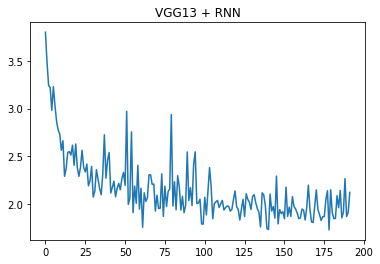

In [63]:
with open(loss_file, 'rb') as ls:
                los_ses = pickle.load(ls)
print("Final loss:", los_ses[-1].item())
ploss=[i.item() for i in los_ses]
plt.title('VGG13 + RNN')
plt.plot(ploss)

Final perplexity: 8.346166486397664


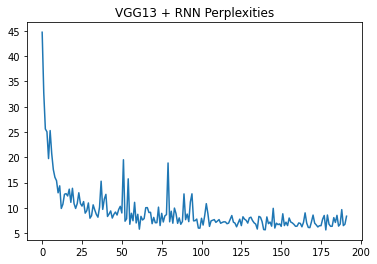

In [64]:
with open(perplexity_file, 'rb') as ps:
                perplex_ses = pickle.load(ps)
print("Final perplexity:", perplex_ses[-1].item())
plex=[i.item() for i in perplex_ses]
plt.title('VGG13 + RNN Perplexities')
plt.plot(plex)

# Testing

## Define testing dataloader
* define a transform to pre-process the testing images
* initialize a testing dataloader

In [65]:
# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])

# Create the data loader.
test_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


## Load pretrained model

In [66]:
#Get vocabulary size
vocab_size = len(test_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))
#uncomment this if you aren't using a GPU
#encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file),map_location=torch.device('cpu')))
#decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file),map_location=torch.device('cpu')))

encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding_layer): Embedding(8852, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8852, bias=True)
)

## Display a single image + caption prediction

In [67]:
def get_prediction(encoder, decoder, test_loader):
    orig_image, image = next(iter(test_loader))
    #print('orig_image ' , orig_image.shape)
    print('image: ' , image.shape)
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output, test_loader)
    print(sentence)

def clean_sentence(output, data_loader):
    words_sequence = []
    for i in output:
        if (i == 1):
            continue
        words_sequence.append(data_loader.dataset.vocab.idx2word[i])
    words_sequence = words_sequence[1:-1] 
    sentence = ' '.join(words_sequence) 
    sentence = sentence.capitalize()    
    return sentence

image:  torch.Size([1, 3, 224, 224])


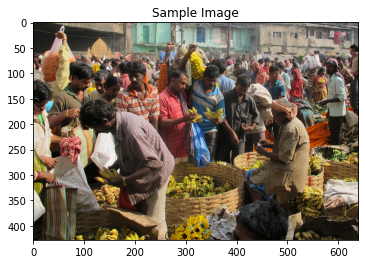

A group of people standing around a table with food .


In [68]:
get_prediction(encoder, decoder, test_loader)

## Calculate BLEU score
Calculate the BLEU score of the model over the entire dataset by averaging the BLEU scores over several batches.

### Define a data loader
This data loader should return images and their corresponding ground-truth captions from the validation dataset.

In [69]:
transform_val = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])
val_loader = get_loader(transform=transform_val,
                         mode='val',batch_size=batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 790/202654 [00:00<00:25, 7899.05it/s]

Done (t=0.31s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:23<00:00, 8665.56it/s]


### Define functions

In [70]:
def clean_sentence_bleu(output, data_loader):
    words_sequence = []
    for i in output:
        i = int(i)
        if (i == 1):
            continue
        words_sequence.append(data_loader.dataset.vocab.idx2word[i])
    words_sequence = words_sequence[1:-1] 
#   sentence = ' '.join(words_sequence) 
#   sentence = sentence.capitalize()    
    return words_sequence

def get_avg_bleu(encoder, decoder, dataloader, device):
    '''Determine the average BLEU score across the entire dataset
    '''
    with torch.no_grad():
        total_score1 = 0
        total_score2 = 0
        total_score3 = 0
        total_score4 = 0
        total_num = 0
        for data in tqdm(dataloader):
            torch.cuda.empty_cache()
            print("STARTING NEW BATCH")
            #load images and reference captions from the dataset
            images, captions_ref = data
            images = images.to(device)
            print('captions_ref: ',captions_ref.type())
            # Get caption predictions for the current batch of validation images
            captions_cand = get_batch_candidates(encoder, decoder, images)
            
            #calculate the bleu score for the entire batch
            print(captions_ref.shape)
            refs = []
            cands = []
            for captions in captions_ref:
                #captions = captions.float()
                #print(captions.type())
                refs.append(clean_sentence_bleu(captions, dataloader))
                
            for captions_2 in captions_cand:
                cands.append(clean_sentence_bleu(captions_2, dataloader))
#             print(refs.size())
#             print(cands.size())
            #batch_score = get_batch_bleu(captions_ref, captions_cand)
            batch_score1, batch_score2, batch_score3, batch_score4 = get_batch_bleu(refs, cands)
            #increment total_score and total_num
            total_score1 = total_score1 + batch_score1
            total_score2 = total_score2 + batch_score2
            total_score3 = total_score3 + batch_score3
            total_score4 = total_score4 + batch_score4
            
            total_num = total_num + dataloader.dataset.batch_size
        
            
            #print('Total Num: ',total_num)
            
        avg_score1 = total_score1/total_num
        avg_score2 = total_score2/total_num
        avg_score3 = total_score3/total_num
        avg_score4 = total_score4/total_num
        
        return avg_score1, avg_score2, avg_score3, avg_score4

def get_batch_candidates(encoder, decoder, images):
    '''Gets predictions for the current batch of images
    '''
    with torch.no_grad():
        captions_cand = []

        features_batch = encoder(images).unsqueeze(1)

        for features in features_batch:
            new_cand = decoder.sample(features.unsqueeze(0))
            captions_cand.append(new_cand)

        return torch.Tensor(captions_cand)

def get_batch_bleu(captions_ref, captions_cand):
    '''Compute the total BLEU score over elements in a batch
    '''
    with torch.no_grad():
        scores1 = 0
        scores2 = 0
        scores3 = 0
        scores4 = 0
        for i in range(len(captions_ref)):
            #print(len(ref))
            captions_cand[i] = [x for x in captions_cand[i] if x != '.']
            print('captions_ref= ',captions_ref[i])
            print('captions_cand= ',captions_cand[i])
            scores1 += nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i], weights=(1, 0, 0, 0))
            scores2 += nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i], weights=(0.5, 0.5, 0, 0))
            scores3 += nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i], weights=(0.33, 0.33, 0.33, 0.33))
            scores4 += nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i], weights=(0.25, 0.25, 0.25, 0.25))
            print('Score : ',nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i],weights=(1, 0, 0, 0)))
            print('Score : ',nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i],weights=(0.5, 0.5, 0, 0)))
            print('Score : ',nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i],weights=(0.33, 0.33, 0.33, 0)))
            print('Score : ',nltk.translate.bleu_score.sentence_bleu([captions_ref[i]], captions_cand[i],weights=(0.25, 0.25, 0.25, 0.25)))
        return scores1, scores2, scores3, scores4

### Calculate

In [71]:
bleu_score1, bleu_score2, bleu_score3, bleu_score4 = get_avg_bleu(encoder, decoder, val_loader, device)
print([bleu_score1, bleu_score2, bleu_score3, bleu_score4])

  0%|          | 0/1 [00:00<?, ?it/s]

captions_ref:  torch.LongTensor


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]

torch.Size([64, 11])
captions_ref=  ['a', 'group', 'of', 'young', 'men', 'are', 'playing', 'soccer']
captions_cand=  ['a', 'group', 'of', 'young', 'boys', 'playing', 'soccer', 'in', 'a', 'field']
Score :  0.6
Score :  0.5163977794943222
Score :  0.4091569047284194
Score :  0.31239399369202553
captions_ref=  ['there', 'are', 'many', 'people', 'standing', 'together', 'y', 'a']
captions_cand=  ['a', 'group', 'of', 'people', 'standing', 'around', 'a', 'table', 'with', 'umbrellas']
Score :  0.3
Score :  0.18257418583505533
Score :  9.708980935455592e-103
Score :  6.373704167435469e-155
captions_ref=  ['a', 'sheep', 'stands', 'on', 'the', 'hillside', 'with', 'rocks']
captions_cand=  ['a', 'brown', 'and', 'white', 'cow', 'standing', 'on', 'top', 'of', 'a', 'lush', 'green', 'field']
Score :  0.15384615384615385
Score :  5.850803834986753e-155
Score :  4.7971789246899324e-204
Score :  1.1409851298103347e-231
captions_ref=  ['a', 'helicopter', 'is', 'flying', 'in', 'the', 'clear', 'sky']
caption